In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
data_file = '../../../Udacity-SDC-dataset/behavioral-cloning-data/driving_log.csv'
img_folder = '../../../Udacity-SDC-dataset/behavioral-cloning-data/'
df = pd.read_csv(data_file, skipinitialspace=True, usecols=[0, 1, 2, 3])
print(df.shape)
df.head(3)

(8036, 4)


,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0


### Visualize data distribution

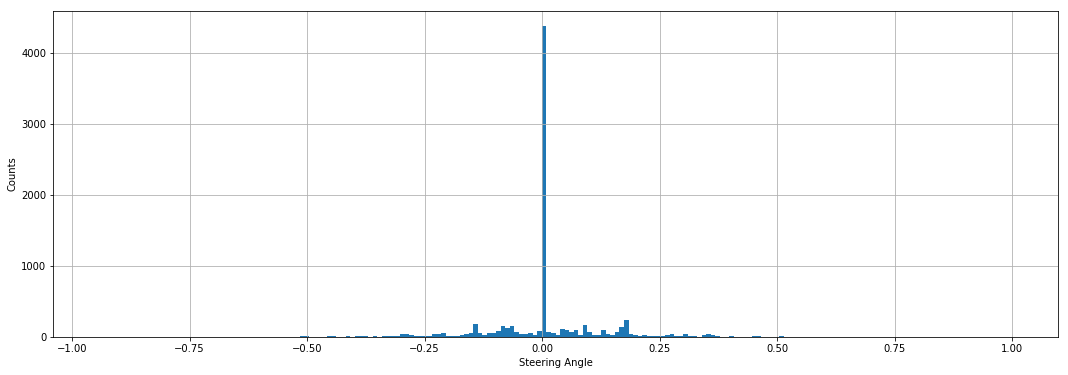

Total Data: 8036
Total Zeros: 4361


In [2]:
plt.figure(figsize=(18, 6))
df.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()
print("Total Data:", len(df.steering))
print("Total Zeros:",len(df[df.steering == 0]))

### Drop out zeros to balance data

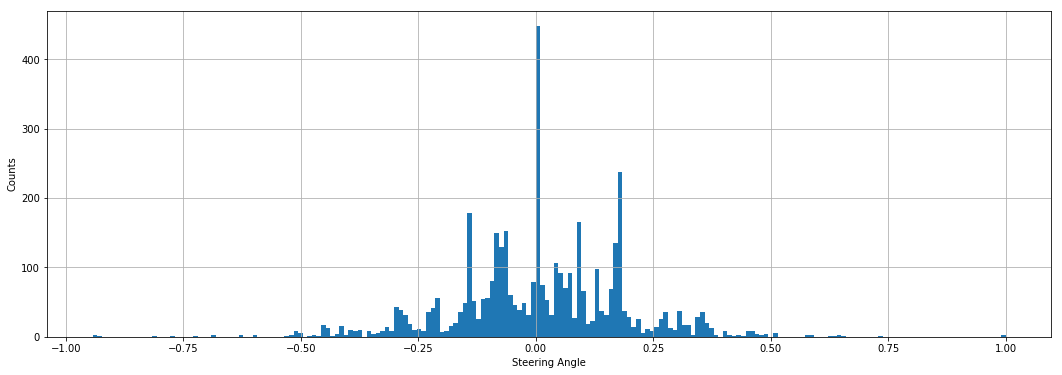

Total Data: 4111
Total Zeros: 436


In [3]:
zero_steering = df[df.steering == 0].sample(frac=0.9)
new_df = df.drop(zero_steering.index)
plt.figure(figsize=(18, 6))
new_df.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()
print("Total Data:", len(new_df.steering))
print("Total Zeros:",len(new_df[new_df.steering == 0]))

### Add more data by shifting left and right angles

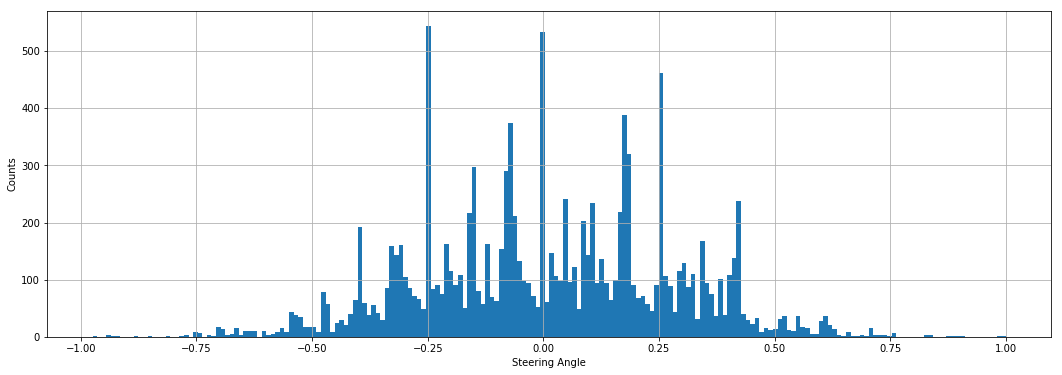

,image,steering
0,IMG/left_2016_12_01_13_31_13_381.jpg,0.25
1,IMG/center_2016_12_01_13_31_13_381.jpg,0.00
2,IMG/right_2016_12_01_13_31_13_381.jpg,-0.25


,image,steering
12330,IMG/left_2016_12_01_13_46_38_599.jpg,0.25
12331,IMG/center_2016_12_01_13_46_38_599.jpg,0.00
12332,IMG/right_2016_12_01_13_46_38_599.jpg,-0.25


Total Data: 12325
Total Zeros: 436


In [4]:
def steering_shift(df):
    data = []
    for i, row in new_df.iterrows():
        data.append({
            'image': row.left,
            'steering': row.steering + 0.25
        })
        data.append({
            'image': row.center,
            'steering': row.steering
        })
        data.append({
            'image': row.right,
            'steering': row.steering - 0.25
        })
    return pd.DataFrame(data=data, columns=['image', 'steering'])

shift_df = steering_shift(df)
outbound_steering = shift_df[abs(shift_df.steering) > 1]
shift_df = shift_df.drop(outbound_steering.index)

plt.figure(figsize=(18, 6))
shift_df.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()
display(shift_df.head(3))
display(shift_df.tail(3))
print("Total Data:", len(shift_df.steering))
print("Total Zeros:",len(shift_df[shift_df.steering == 0]))

### Flip steering angles

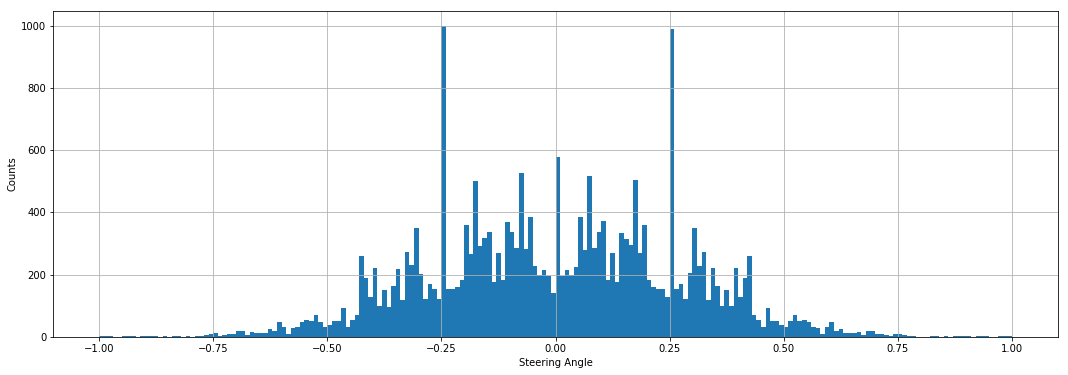

Total Data 24095
Total Zeros: 436


,image,steering,flipped
0,IMG/left_2016_12_01_13_31_13_381.jpg,0.25,False
1,IMG/center_2016_12_01_13_31_13_381.jpg,0.00,False
2,IMG/right_2016_12_01_13_31_13_381.jpg,-0.25,False


,image,steering,flipped
24092,IMG/center_2016_12_01_13_42_59_727.jpg,0.069252,True
24093,IMG/right_2016_12_01_13_45_08_042.jpg,-0.156227,True
24094,IMG/left_2016_12_01_13_38_15_269.jpg,-0.302191,True


In [5]:
def steering_flip(df):
    df.loc[:, 'flipped'] = False
    new_df = df[df.steering != 0].sample(frac=0.99) 
    new_df.loc[:,'flipped'] = True
    new_df.loc[:, 'steering'] = new_df.steering * -1
    return pd.concat([df, new_df])

steering_combined = steering_flip(shift_df)
# reset index
steering_combined = steering_combined.reset_index(drop=True)

plt.figure(figsize=(18, 6))
steering_combined.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()
print("Total Data", len(steering_combined.steering))
print("Total Zeros:",len(steering_combined[steering_combined.steering == 0]))
display(steering_combined.head(3))
display(steering_combined.tail(3))

### Dropping out steering angles with more than 400 counts

,angles,counts
0,-0.250000,869
1,0.250000,866
2,0.000000,436
3,-0.073418,237
4,0.426582,237


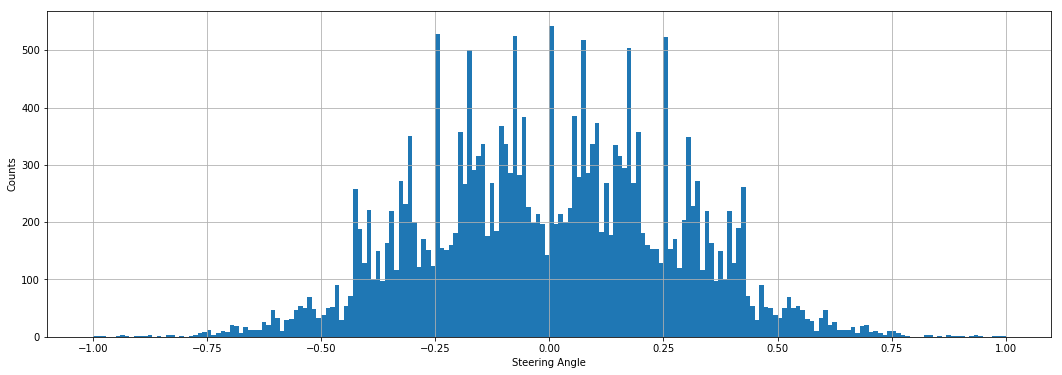

Total Data: 23124


In [6]:
count_max = 400
angles = steering_combined.steering.value_counts().index.tolist()
counts = steering_combined.steering.value_counts().tolist()

test = pd.DataFrame({
    'angles': angles,
    'counts': counts
})
display(test.head())

for i, row in test.iterrows():
    if row.counts > count_max:
        drop_frac = (row.counts-count_max)/(row.counts)
        drop_steering = steering_combined[steering_combined.steering == (row.angles)].sample(frac=drop_frac)
        steering_combined = steering_combined.drop(drop_steering.index)

plt.figure(figsize=(18, 6))
steering_combined.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()

# reset index
steering_combined = steering_combined.reset_index(drop=True)
print("Total Data:", len(steering_combined.steering))


In [7]:
steering_combined.to_csv('prep_driving_log.csv')

In [8]:
data_file = 'prep_driving_log.csv'
img_folder = '../../../Udacity-SDC-dataset/behavioral-cloning-data/'
df = pd.read_csv(data_file, skipinitialspace=True, usecols=[0, 1, 2, 3])
print(df.shape)
display(df.head(3))
display(df.tail(3))

(23124, 4)


,Unnamed: 0,image,steering,flipped
0,0,IMG/left_2016_12_01_13_31_13_381.jpg,0.25,False
1,1,IMG/center_2016_12_01_13_31_13_381.jpg,0.00,False
2,2,IMG/right_2016_12_01_13_31_13_381.jpg,-0.25,False


,Unnamed: 0,image,steering,flipped
23121,23121,IMG/center_2016_12_01_13_42_59_727.jpg,0.069252,True
23122,23122,IMG/right_2016_12_01_13_45_08_042.jpg,-0.156227,True
23123,23123,IMG/left_2016_12_01_13_38_15_269.jpg,-0.302191,True


In [9]:
%%time
import os
import matplotlib.image as mpimg
import cv2


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.7 µs


### Preprocess functions

In [10]:
def CropImage(image):
    return image[66:135, 0:319]

def ResizeImage(image):
    return cv2.resize(CropImage(image), (64, 14), cv2.INTER_AREA)
    #return cv2.resize(CropImage(image), (32, 7), cv2.INTER_AREA)

def RGB_to_S(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]

def FlipImage(image):
    return cv2.flip(image, 1)


### This will take a while
#### resize and save as pickle

In [11]:
img_folder = '../../../Udacity-SDC-dataset/behavioral-cloning-data/'

image_list = []
steering_list = []

for i, row in df.iterrows():
    img = mpimg.imread(img_folder + row.image)
    if (row.flipped):
        img = FlipImage(img)
    img = ResizeImage(img)
    img = RGB_to_S(img)
    image_list.append(img)
    steering_list.append(row.steering)

image_list = np.asarray(image_list)
steering_list = np.asarray(steering_list)
image_list = image_list.reshape(image_list.shape + (1,))
print(image_list.shape)
print(steering_list.shape)

(23124, 14, 64, 1)
(23124,)


In [12]:
import pickle
train_file = 'train.p'

pickle.dump({
        "features" : image_list,
        "labels" : steering_list
    }, open(train_file, "wb" ) )
print('train data saved')

train data saved


### Load pickle file

In [13]:
import pickle
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
train_file = 'train.p'

with open(train_file, mode='rb') as f:
    train = pickle.load(f)

X_train, y_train = train['features'], train['labels']


### Split training set and validation set

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=0, test_size=0.1)

-0.0787459


'\nplt.figure(figsize=(10, 10))\nplt.imshow(X_train[2].squeeze())\nprint(y_train[2])\nplt.figure(figsize=(10, 10))\nplt.imshow(X_train[3].squeeze())\nprint(y_train[3])\n'

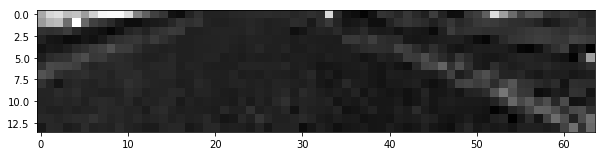

In [15]:
angle_ID = np.random.randint(0, len(X_train))
plt.figure(figsize=(10, 10))
plt.imshow(X_train[angle_ID].squeeze(),cmap='gray')
print(y_train[angle_ID])


In [16]:
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam

model = Sequential([
Lambda(lambda x: x/127.5-1.,input_shape=(14, 64, 1)),
Conv2D(2, 3, 3, border_mode='valid', input_shape=(14, 64, 1), activation='relu'),
MaxPooling2D((4,4),(4,4),'valid'),
Dropout(0.25),
Flatten(),
Dense(1)
])
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 14, 64, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 12, 62, 2)     20          lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 3, 15, 2)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 3, 15, 2)      0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [17]:
%%time
batch_size=128
nb_epoch=10
model.compile(loss='mean_squared_error',optimizer=Adam(lr=1e-3))#,
              #metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    nb_epoch=nb_epoch,verbose=1, 
                    validation_data=(X_val, y_val))

Train on 20811 samples, validate on 2313 samples
Epoch 1/10
20811/20811 [==============================] - 1s - loss: 0.2290 - val_loss: 0.0598
Epoch 2/10
20811/20811 [==============================] - 0s - loss: 0.0713 - val_loss: 0.0416
Epoch 3/10
20811/20811 [==============================] - 0s - loss: 0.0509 - val_loss: 0.0365
Epoch 4/10
20811/20811 [==============================] - 0s - loss: 0.0432 - val_loss: 0.0341
Epoch 5/10
20811/20811 [==============================] - 0s - loss: 0.0386 - val_loss: 0.0326
Epoch 6/10
20811/20811 [==============================] - 0s - loss: 0.0367 - val_loss: 0.0320
Epoch 7/10
20811/20811 [==============================] - 0s - loss: 0.0348 - val_loss: 0.0311
Epoch 8/10
20811/20811 [==============================] - 0s - loss: 0.0338 - val_loss: 0.0305
Epoch 9/10
20811/20811 [==============================] - 0s - loss: 0.0333 - val_loss: 0.0304
Epoch 10/10
20811/20811 [==============================] - 0s - loss: 0.0328 - val_loss: 0.0298


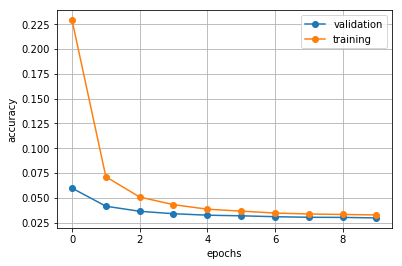

In [18]:

plt.plot(history.epoch,history.history['val_loss'],'-o',label='validation')
plt.plot(history.epoch,history.history['loss'],'-o',label='training')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)

In [19]:
model.save("model.h5")

with open("model.json", "w") as json_file:
  json_file.write(model.to_json())

print("Model Saved.")

Model Saved.
